In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=de2246f0629ab2439b31583a532d26676e0e9da6bf14f62297f5e19bf80a97db
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import KBinsDiscretizer
import ta

In [ ]:
seq_length = 64
d_model = 16
nhead = 4
num_layers = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

shuffle = True

batch_size = 32

In [ ]:
# Define your stock and data parameters
stock = '^GSPC'

def get_stock(stock_choice):
    start, end = '', ''
    if stock_choice == '^GSPC':
        start = '1980-01-01'
        end = '2024-08-10'
    elif stock_choice == 'AAPL':
        start = '1984-12-12'
        end = '2024-08-10'
    elif stock_choice == '^DJI':
        start = '1980-01-01'
        end = '2024-08-10'
    elif stock_choice == 'PFE':
        start = '1980-01-01'
        end = '2024-08-10'
    elif stock_choice == 'GOOGL':
        start = '2004-08-19'
        end = '2024-08-10'
    elif stock_choice == 'TSLA':
        start = '2010-06-29'
        end = '2024-08-10'
    else:
        start = '2010-01-01'
        end = '2024-08-10'

    return start, end

start, end = get_stock(stock)

# Download stock data
yfd = yf.download(stock, start=start, end=end)

# Select only the closing price
features = ['Close']
df = yfd[features].dropna()

# Normalize the data
std = df.std()
mean = df.mean()

normalized_data = (df - mean) / std

print(normalized_data.head())

# Create sequences
seq_length = 10  # Example sequence length, adjust as needed
X = []
y = []

for i in range(len(normalized_data) - seq_length - 1):
    X.append(normalized_data.iloc[i:i + seq_length].values)
    y.append(normalized_data.iloc[i + seq_length])  # Predicting the next day's percent change

X = np.array(X)
y = np.array(y)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

# Create original indices
original_indices = np.arange(len(X_tensor))

# Split data
x_train, x_temp, y_train, y_temp, train_indices, temp_indices = train_test_split(
    X_tensor, y_tensor, original_indices, test_size=0.3, random_state=42, shuffle=True)

x_val, x_test, y_val, y_test, val_indices, test_indices = train_test_split(
    x_temp, y_temp, temp_indices, test_size=0.5, random_state=42, shuffle=False)

# Create TensorDatasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Create DataLoaders
batch_size = 32  # Adjust this as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

[*********************100%***********************]  1 of 1 completed


               Close
Date                
1980-01-02 -1.011258
1980-01-03 -1.011707
1980-01-04 -1.010626
1980-01-07 -1.010385
1980-01-08 -1.008605


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add a batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]  # Broadcast along the batch size
        return x

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, seq_length):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_length)

        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)

        # Adjust the final output layer to predict a single value
        self.fc_out = nn.Linear(d_model * seq_length, 1)

    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)

        # Flatten the output from transformer encoder to feed into the final linear layer
        output = output.view(output.size(0), -1)
        output = self.fc_out(output)  # Predict a single value
        return output


In [ ]:
# Define model parameters
input_dim = X_tensor.shape[2]  # Number of features, now 3 with the addition of Max_Range
d_model = 16  # Dimension of the model
nhead = 4  # Number of attention heads
num_encoder_layers = 2  # Number of encoder layers
dim_feedforward = 64  # Dimension of the feedforward network
seq_length = X_tensor.shape[1]  # Sequence length

model = TransformerModel(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, seq_length).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
# Custom loss function
class PricePercentChangeLoss(nn.Module):
    def __init__(self, weight_price=1.0, weight_pct_change=1.0):
        super(PricePercentChangeLoss, self).__init__()
        self.weight_price = weight_price
        self.weight_pct_change = weight_pct_change
        self.mse_loss = nn.MSELoss()  # Standard MSE loss for closing price

    def forward(self, outputs, targets, prev_closing_price):
        # Calculate MSE for closing price
        price_loss = self.mse_loss(outputs, targets)

        # Calculate percent change for predicted and actual closing prices
        predicted_pct_change = (outputs - prev_closing_price) / prev_closing_price
        actual_pct_change = (targets - prev_closing_price) / prev_closing_price

        # Calculate MSE for percent change
        pct_change_loss = self.mse_loss(predicted_pct_change, actual_pct_change)

        # Combine both losses
        total_loss = self.weight_price * price_loss + self.weight_pct_change * pct_change_loss
        return total_loss

# Modify the training loop to use the custom loss function
criterion = PricePercentChangeLoss(weight_price=1.0, weight_pct_change=0.5)  # You can adjust these weights


In [ ]:
epochs = 32
criterion = PricePercentChangeLoss(weight_price=1.0, weight_pct_change=0.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Assuming X_tensor contains sequences and y_tensor contains the next day's closing price

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()  # Clear gradients

        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass: model outputs the predicted closing price
        outputs = model(inputs)

        # Extract the previous day's closing price from the inputs
        prev_closing_price = inputs[:, -1, 0].unsqueeze(-1).to(device)

        # Calculate loss using the custom loss function
        loss = criterion(outputs, targets, prev_closing_price)

        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        running_loss += loss.item()  # Accumulate loss

    average_train_loss = running_loss / len(train_loader)
    print(f"[{epoch+1}/{epochs}, {average_train_loss:.4f}", end='')

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(val_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get the previous day's closing price
            prev_closing_price = inputs[:, -1, 0].unsqueeze(-1).to(device)

            # Calculate validation loss
            loss = criterion(outputs, targets, prev_closing_price)
            val_loss += loss.item()

    average_val_loss = val_loss / len(val_loader)
    print(f", {average_val_loss:.4f}]")



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32, 32, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([24, 1, 1])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  retur

[1/32, 1.0334, 0.9495]
[2/32, 1.0037, 0.9506]
[3/32, 1.0003, 0.9488]
[4/32, 0.9924, 0.9488]
[5/32, 1.0013, 0.9484]
[6/32, 0.9983, 0.9484]
[7/32, 0.9963, 0.9484]
[8/32, 0.9929, 0.9483]
[9/32, 1.0002, 0.9487]
[10/32, 0.9965, 0.9492]
[11/32, 1.0019, 0.9484]
[12/32, 0.9941, 0.9484]
[13/32, 0.9935, 0.9487]
[14/32, 0.9923, 0.9496]
[15/32, 0.9970, 0.9484]
[16/32, 0.9941, 0.9533]
[17/32, 0.9938, 0.9498]
[18/32, 0.9936, 0.9493]
[19/32, 0.9971, 0.9484]
[20/32, 0.9929, 0.9520]
[21/32, 0.9980, 0.9494]
[22/32, 0.9971, 0.9483]
[23/32, 0.9915, 0.9488]
[24/32, 0.9965, 0.9487]
[25/32, 1.0019, 0.9507]
[26/32, 0.9930, 0.9494]
[27/32, 0.9994, 0.9487]
[28/32, 0.9955, 0.9484]
[29/32, 0.9956, 0.9485]
[30/32, 0.9954, 0.9483]
[31/32, 0.9970, 0.9485]
[32/32, 0.9982, 0.9501]


Closing Price Prediction:
MSE: 0.8459, MAE: 0.6887, RMSE: 0.9197

Percent Change Prediction:
MSE: 128291.9062, MAE: 17.4722, RMSE: 358.1786


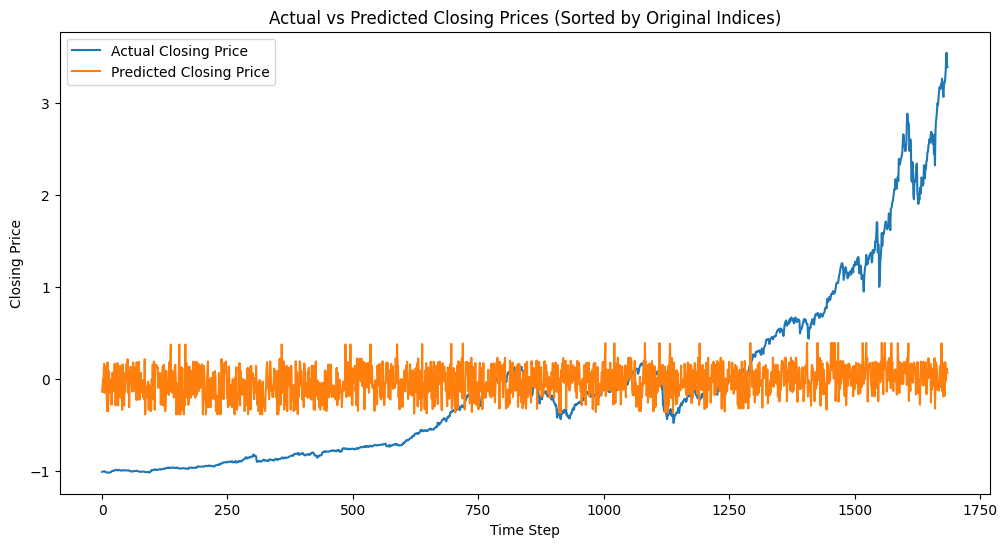

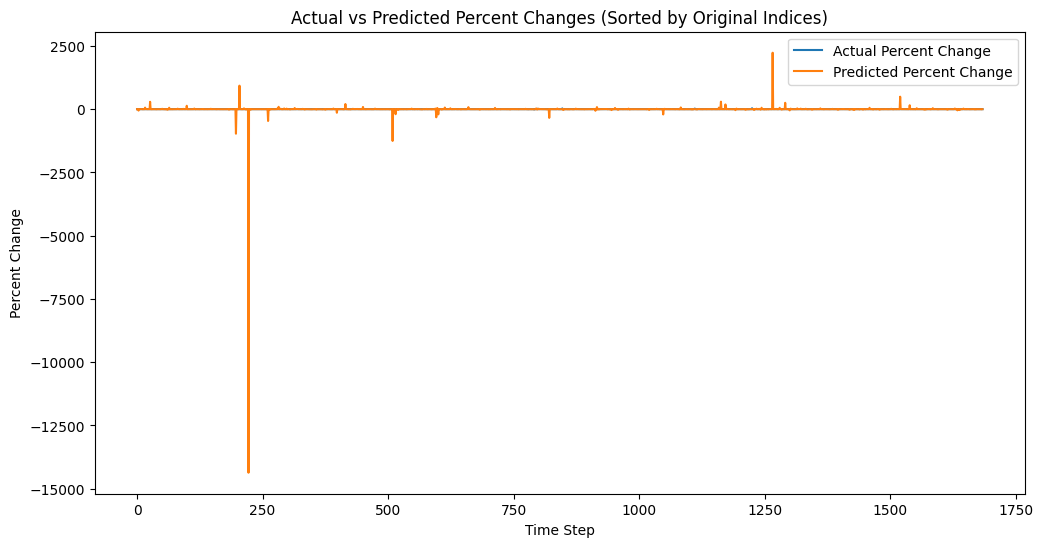

In [ ]:
# Step 3: After training, sort the test data and predictions based on the original indices
def sort_by_original_indices(indices, data):
    # Create a dataframe to sort by original indices
    df = pd.DataFrame({'Original_Index': indices, 'Data': data})
    df_sorted = df.sort_values(by='Original_Index')
    return df_sorted['Data'].values

def evaluate_model(model, data_loader, original_test_indices):
    model.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Store actual and predicted closing prices
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    # Convert lists to numpy arrays for easier calculation
    all_targets = np.array(all_targets).flatten()
    all_predictions = np.array(all_predictions).flatten()

    # Step 4: Sort the results based on the original indices
    all_targets_sorted = sort_by_original_indices(original_test_indices, all_targets)
    all_predictions_sorted = sort_by_original_indices(original_test_indices, all_predictions)

    # Calculate regression metrics for closing price prediction
    mse_price = mean_squared_error(all_targets_sorted, all_predictions_sorted)
    mae_price = mean_absolute_error(all_targets_sorted, all_predictions_sorted)
    rmse_price = np.sqrt(mse_price)

    # Calculate percent changes for both actual and predicted closing prices
    actual_pct_change = (all_targets_sorted[1:] - all_targets_sorted[:-1]) / all_targets_sorted[:-1]
    predicted_pct_change = (all_predictions_sorted[1:] - all_predictions_sorted[:-1]) / all_predictions_sorted[:-1]

    # Calculate regression metrics for percent change prediction
    mse_pct_change = mean_squared_error(actual_pct_change, predicted_pct_change)
    mae_pct_change = mean_absolute_error(actual_pct_change, predicted_pct_change)
    rmse_pct_change = np.sqrt(mse_pct_change)

    # Print evaluation results
    print("Closing Price Prediction:")
    print(f"MSE: {mse_price:.4f}, MAE: {mae_price:.4f}, RMSE: {rmse_price:.4f}")

    print("\nPercent Change Prediction:")
    print(f"MSE: {mse_pct_change:.4f}, MAE: {mae_pct_change:.4f}, RMSE: {rmse_pct_change:.4f}")

    # Plot actual vs predicted closing prices
    plt.figure(figsize=(12, 6))
    plt.plot(all_targets_sorted, label="Actual Closing Price")
    plt.plot(all_predictions_sorted, label="Predicted Closing Price")
    plt.title("Actual vs Predicted Closing Prices (Sorted by Original Indices)")
    plt.xlabel("Time Step")
    plt.ylabel("Closing Price")
    plt.legend()
    plt.show()

    # Plot actual vs predicted percent changes
    plt.figure(figsize=(12, 6))
    plt.plot(actual_pct_change, label="Actual Percent Change")
    plt.plot(predicted_pct_change, label="Predicted Percent Change")
    plt.title("Actual vs Predicted Percent Changes (Sorted by Original Indices)")
    plt.xlabel("Time Step")
    plt.ylabel("Percent Change")
    plt.legend()
    plt.show()

# Step 5: Evaluate the model using the sorted test set
evaluate_model(model, test_loader, test_indices)